# Importing basic Libraries and setting up device

In [2]:
import torch
from torch import nn

In [3]:
device = "cuda" if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

# Get /  Download the data from Github

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
movie_data_path = data_path / "Rotten_tomato_movie"

# If the image folder doesn't exist, download it and prepare it...
if movie_data_path.is_dir():
    print(f"{movie_data_path} directory exists.")
else:
    print(f"Did not find {movie_data_path} directory, creating one...")
    movie_data_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "Rotten_Tomatoes_Movies3.xls.zip", "wb") as f:
        request = requests.get("https://github.com/yuvrajkari7/Rotten_tomatoe_ZOHO/raw/main/Rotten_Tomatoes_Movies3.xls.zip")
        print("Downloading Rotten tomato movie data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "Rotten_Tomatoes_Movies3.xls.zip", "r") as zip_ref:
        print("Unzipping Rotten tomato movie data...")
        zip_ref.extractall(movie_data_path)

Did not find data/Rotten_tomato_movie directory, creating one...
Unzipping Rotten tomato movie data...


# Importing basic Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# Importing and Exploring The Data

In [41]:
df_movies=pd.read_excel(movie_data_path / "Rotten_Tomatoes_Movies3.xls")
df_movies.head()

,movie_title,movie_info,critics_consensus,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating
0,Percy Jackson & the Olympians: The Lightning T...,A teenager discovers he's the descendant of a ...,Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,Craig Titley,"Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,2010-06-29,83.0,20th Century Fox,Rotten,49,144,53.0
1,Please Give,Kate has a lot on her mind. There's the ethics...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,2010-10-19,90.0,Sony Pictures Classics,Certified Fresh,86,140,64.0
2,10,Blake Edwards' 10 stars Dudley Moore as George...,NaN,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,1997-08-27,118.0,Waner Bros.,Fresh,68,22,53.0
3,12 Angry Men (Twelve Angry Men),"A Puerto Rican youth is on trial for murder, a...",Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,2001-03-06,95.0,Criterion Collection,Certified Fresh,100,51,97.0
4,"20,000 Leagues Under The Sea","This 1954 Disney version of Jules Verne's 20,0...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,2003-05-20,127.0,Disney,Fresh,89,27,74.0


In [7]:
df_movies.shape

(16638, 16)

In [8]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16638 entries, 0 to 16637
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   movie_title         16638 non-null  object        
 1   movie_info          16614 non-null  object        
 2   critics_consensus   8309 non-null   object        
 3   rating              16638 non-null  object        
 4   genre               16621 non-null  object        
 5   directors           16524 non-null  object        
 6   writers             15289 non-null  object        
 7   cast                16354 non-null  object        
 8   in_theaters_date    15823 non-null  datetime64[ns]
 9   on_streaming_date   16636 non-null  datetime64[ns]
 10  runtime_in_minutes  16483 non-null  float64       
 11  studio_name         16222 non-null  object        
 12  tomatometer_status  16638 non-null  object        
 13  tomatometer_rating  16638 non-null  int64     

In [9]:
# find the null values in the dataframe in ascending order
df_movies.isnull().sum().sort_values(ascending=False)

,0
critics_consensus,8329
writers,1349
in_theaters_date,815
studio_name,416
cast,284
audience_rating,252
runtime_in_minutes,155
directors,114
movie_info,24
genre,17


In [10]:
df_movies.drop('critics_consensus', axis=1, inplace=True)

In [11]:
df_movies.dropna(inplace=True, axis=0)

In [12]:
df_movies.shape

(14090, 15)

In [13]:
#Checking Duplicated Data in the dataframe
df_movies.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

In [14]:
df_movies.select_dtypes('object').nunique()

,0
movie_title,13667
movie_info,14090
rating,8
genre,979
directors,6877
writers,11157
cast,14087
studio_name,2386
tomatometer_status,3


In [15]:
#Number of directors in each movie
df_movies['num_directors'] = df_movies['directors'].apply(lambda x : len(x.split(',')))
#Movie with the highest number of directors
df_movies[df_movies["num_directors"] == df_movies["num_directors"].max()]

,movie_title,movie_info,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,num_directors
10976,Paris Je T'aime,Twenty acclaimed filmmakers from around the wo...,R,"Art House & International, Drama, Romance","Christoffer Boe, Olivier Assayas, Fr√©d√©ric A...","Bruno Podalyd√®s, Paul Mayeda Berges, Gurinder...","Juliette Binoche, Steve Buscemi, Sergio Castel...",2007-05-04,2007-11-13,120.0,First Look Pictures,Certified Fresh,87,112,84.0,22


In [16]:
#Number of actors in each movie
df_movies['num_actors'] = df_movies['cast'].apply(lambda x : len(x.split(',')))
#Movie with the highest number of actors
df_movies[df_movies["num_actors"] == df_movies["num_actors"].max()]

,movie_title,movie_info,rating,genre,directors,writers,cast,in_theaters_date,on_streaming_date,runtime_in_minutes,studio_name,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,num_directors,num_actors
912,Malcolm X,Writer-director Spike Lee's epic portrayal of ...,PG-13,Drama,Spike Lee,"Spike Lee, Arnold Perl","Denzel Washington, Angela Bassett, Al Freeman ...",1992-11-18,2000-01-18,201.0,Warner Bros.,Certified Fresh,88,57,91.0,1,306


In [17]:
print(f'Movie with the highest runtime: \n{df_movies[df_movies["runtime_in_minutes"] == df_movies["runtime_in_minutes"].max()][["runtime_in_minutes", "movie_title"]]}')
print(f'Movie with the lowest runtime: \n{df_movies[df_movies["runtime_in_minutes"] == df_movies["runtime_in_minutes"].min()][["runtime_in_minutes", "movie_title"]].iloc[0]}')

Movie with the highest runtime: 
       runtime_in_minutes   movie_title
13539              2000.0  Terror Tract
Movie with the lowest runtime: 
runtime_in_minutes           1.0
movie_title           The Border
Name: 323, dtype: object


rating
R         5650
NR        3299
PG-13     2672
PG        1851
G          580
NC17        34
PG-13)       3
R)           1
Name: count, dtype: int64


<ipython-input-21-c721f88e93a1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_movies, x='rating',hue=None,palette="tab10",legend=False)


Text(0.5, 1.0, 'Content Ratings Counts')

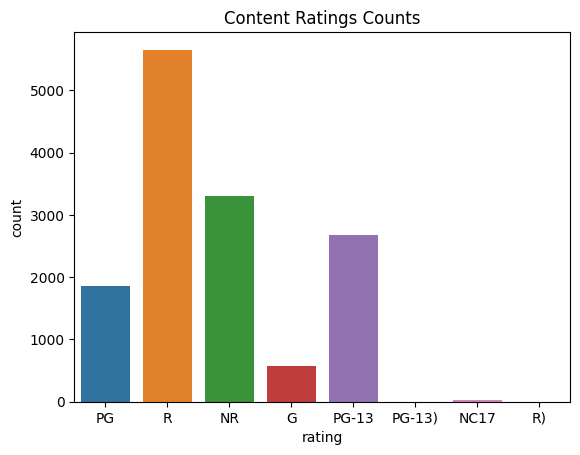

In [21]:
#Content Ratings Counts
print(df_movies['rating'].value_counts())
sns.countplot(data=df_movies, x='rating',hue=None,palette="tab10",legend=False)
plt.title('Content Ratings Counts')

tomatometer_status
Rotten             6468
Fresh              4969
Certified Fresh    2653
Name: count, dtype: int64


<ipython-input-22-0ff7a1308429>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_movies, x='tomatometer_status',hue=None,palette="tab10",legend=False)


Text(0.5, 1.0, 'Number of Fresh, Certified Fresh and Rotten Movies')

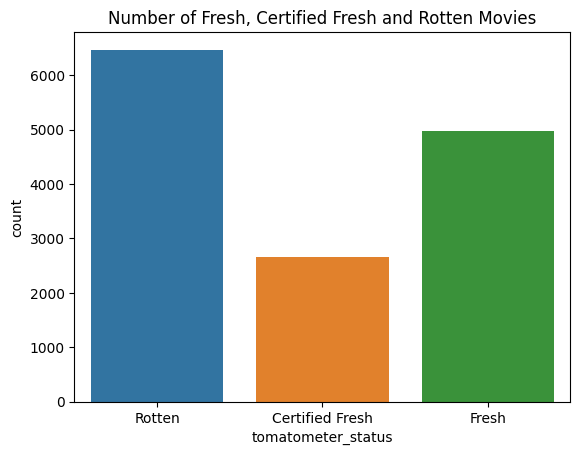

In [22]:
#Number od Fresh, Certified Fresh and Rotten Movies
print(df_movies['tomatometer_status'].value_counts())
sns.countplot(data=df_movies, x='tomatometer_status',hue=None,palette="tab10",legend=False)
plt.title('Number of Fresh, Certified Fresh and Rotten Movies')

In [26]:
#Replacing tomatometer_status with numeric values
df_movies['tomatometer_status'] = df_movies['tomatometer_status'].replace(
    {'Rotten': 0, 'Fresh': 1, 'Certified Fresh': 2}
)


<ipython-input-26-89822136988c>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_movies['tomatometer_status'] = df_movies['tomatometer_status'].replace(


In [27]:
df_movies['tomatometer_status'].value_counts()

,count
tomatometer_status,
0,6468
1,4969
2,2653


studio_name
Paramount Pictures                  473
Warner Bros. Pictures               472
Universal Pictures                  457
20th Century Fox                    404
IFC Films                           355
Sony Pictures Home Entertainment    346
Warner Home Video                   338
MGM                                 246
MGM Home Entertainment              241
Sony Pictures Classics              238
Name: count, dtype: int64


Text(0.5, 1.0, 'Audience Status Counts')

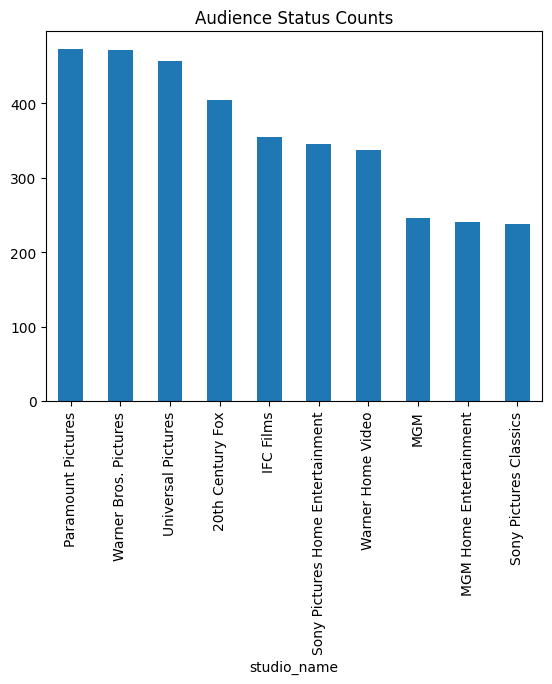

In [28]:
#Number of Movies Produced by top 10 Company
print(df_movies['studio_name'].value_counts()[:10])
df_movies['studio_name'].value_counts()[:10].plot(kind='bar')
plt.title('Audience Status Counts')

In [34]:
#Movies per Year
df_movies['original_release_date'] = pd.to_datetime(df_movies['in_theaters_date'])
df_movies['original_release_year'] = df_movies['in_theaters_date'].dt.year

Year with most number of movies:  2014
Year with least number of movies:  1914


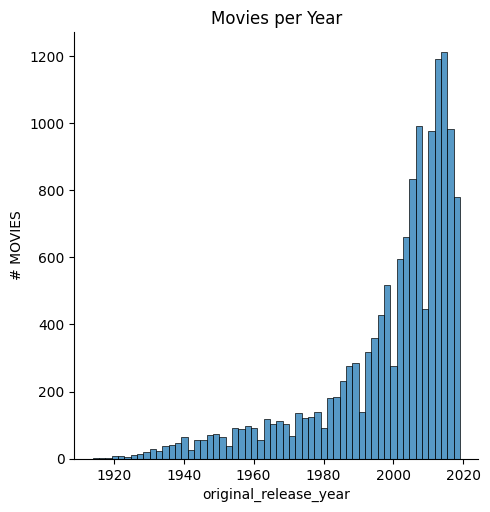

In [35]:
sns.displot(data=df_movies, x='original_release_year')
plt.ylabel('# MOVIES')
plt.title('Movies per Year')
print('Year with most number of movies: ', df_movies['original_release_year'].value_counts().index[0])
print('Year with least number of movies: ', df_movies['original_release_year'].value_counts().index[-1])

Text(0, 0.5, 'Counts')

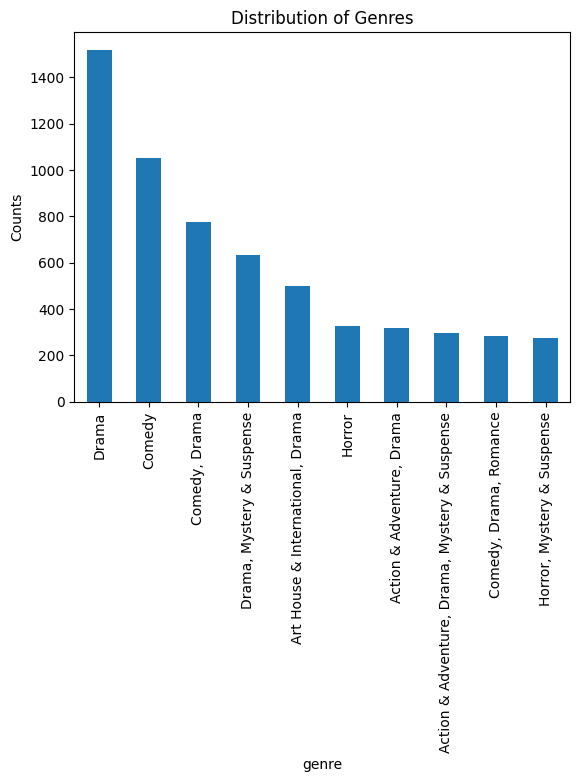

In [37]:
df_movies['genre'].value_counts()[:10].plot(kind='bar')
plt.title('Distribution of Genres')
plt.ylabel('Counts')

In [38]:
df_movies.describe()

,in_theaters_date,on_streaming_date,runtime_in_minutes,tomatometer_status,tomatometer_rating,tomatometer_count,audience_rating,num_directors,num_actors,original_release_date,original_release_year
count,14090,14090.000000,14090.000000,14090.000000,14090.000000,14090.000000,14090.00000,14090.000000,14090.000000,14090,14090.000000
mean,1999-01-14 04:06:30.404542208,2007.580696,103.646842,0.729241,58.903052,61.854365,60.07885,1.122569,27.640667,1999-01-14 04:06:30.404542208,1998.541945
min,1914-06-01 00:00:00,1935.000000,1.000000,0.000000,0.000000,5.000000,0.00000,1.000000,1.000000,1914-06-01 00:00:00,1914.000000
25%,1991-12-27 00:00:00,2002.000000,91.000000,0.000000,36.000000,14.000000,44.00000,1.000000,12.000000,1991-12-27 00:00:00,1991.000000
50%,2005-12-21 00:00:00,2007.000000,100.000000,1.000000,63.000000,32.000000,62.00000,1.000000,22.000000,2005-12-21 00:00:00,2005.000000
75%,2013-02-15 00:00:00,2013.000000,112.000000,1.000000,84.000000,88.000000,77.00000,1.000000,38.000000,2013-02-15 00:00:00,2013.000000
max,2019-10-25 00:00:00,2019.000000,2000.000000,2.000000,100.000000,497.000000,100.00000,22.000000,306.000000,2019-10-25 00:00:00,2019.000000
std,NaN,6.356441,25.548225,0.757673,28.528839,68.860785,20.34867,0.520386,20.719323,NaN,19.736686


<Axes: >

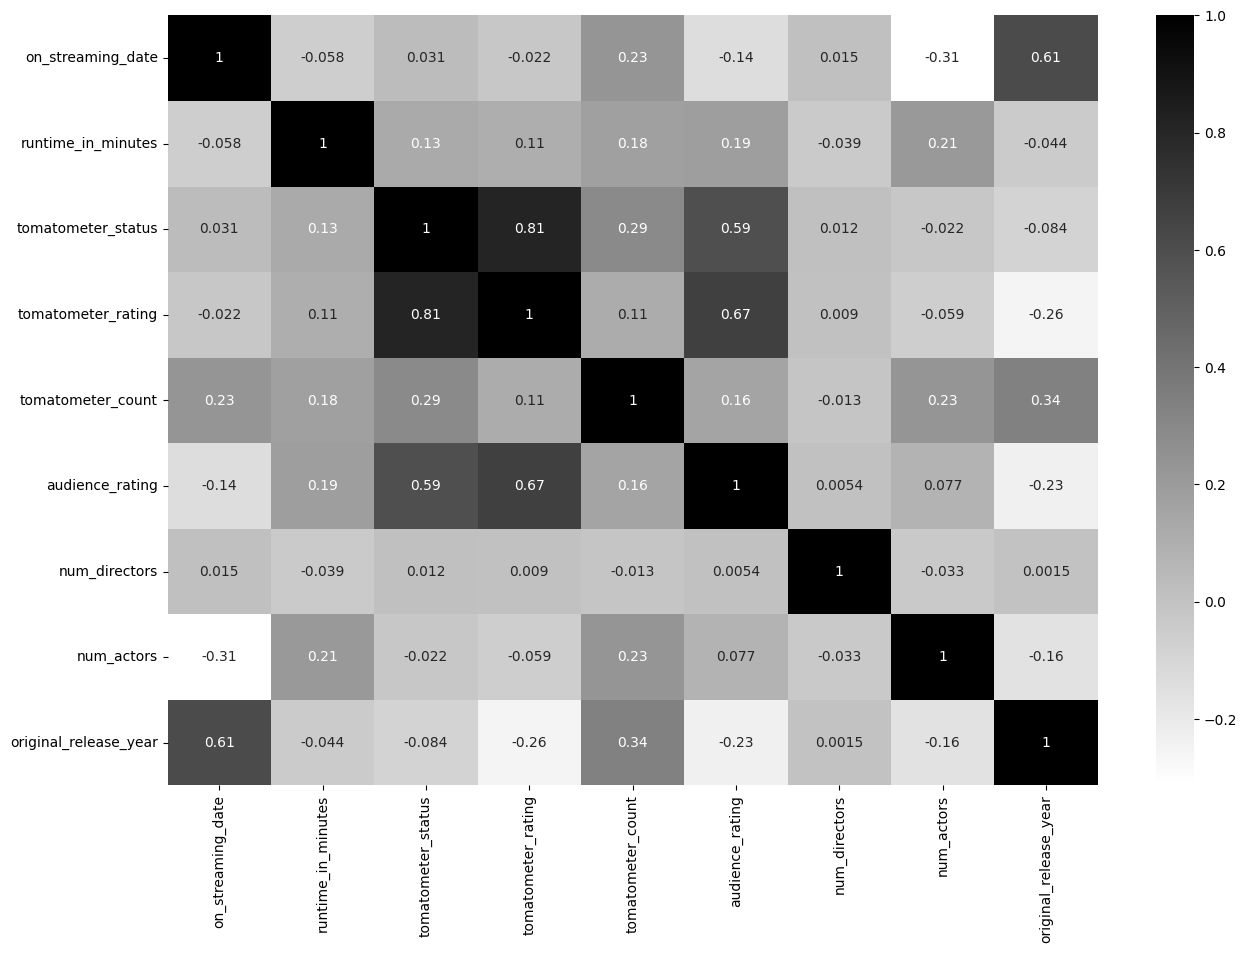

In [39]:
#Correlation
corr = df_movies.select_dtypes('number').corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, cmap='binary')

In [40]:
#Correlation with the target value 'tomatometer_status'
df_movies.select_dtypes('number').corr()['tomatometer_status'].sort_values(ascending=False)

,tomatometer_status
tomatometer_status,1.000000
tomatometer_rating,0.813962
audience_rating,0.590790
tomatometer_count,0.290916
runtime_in_minutes,0.126127
on_streaming_date,0.030910
num_directors,0.011629
num_actors,-0.022036
original_release_year,-0.083762


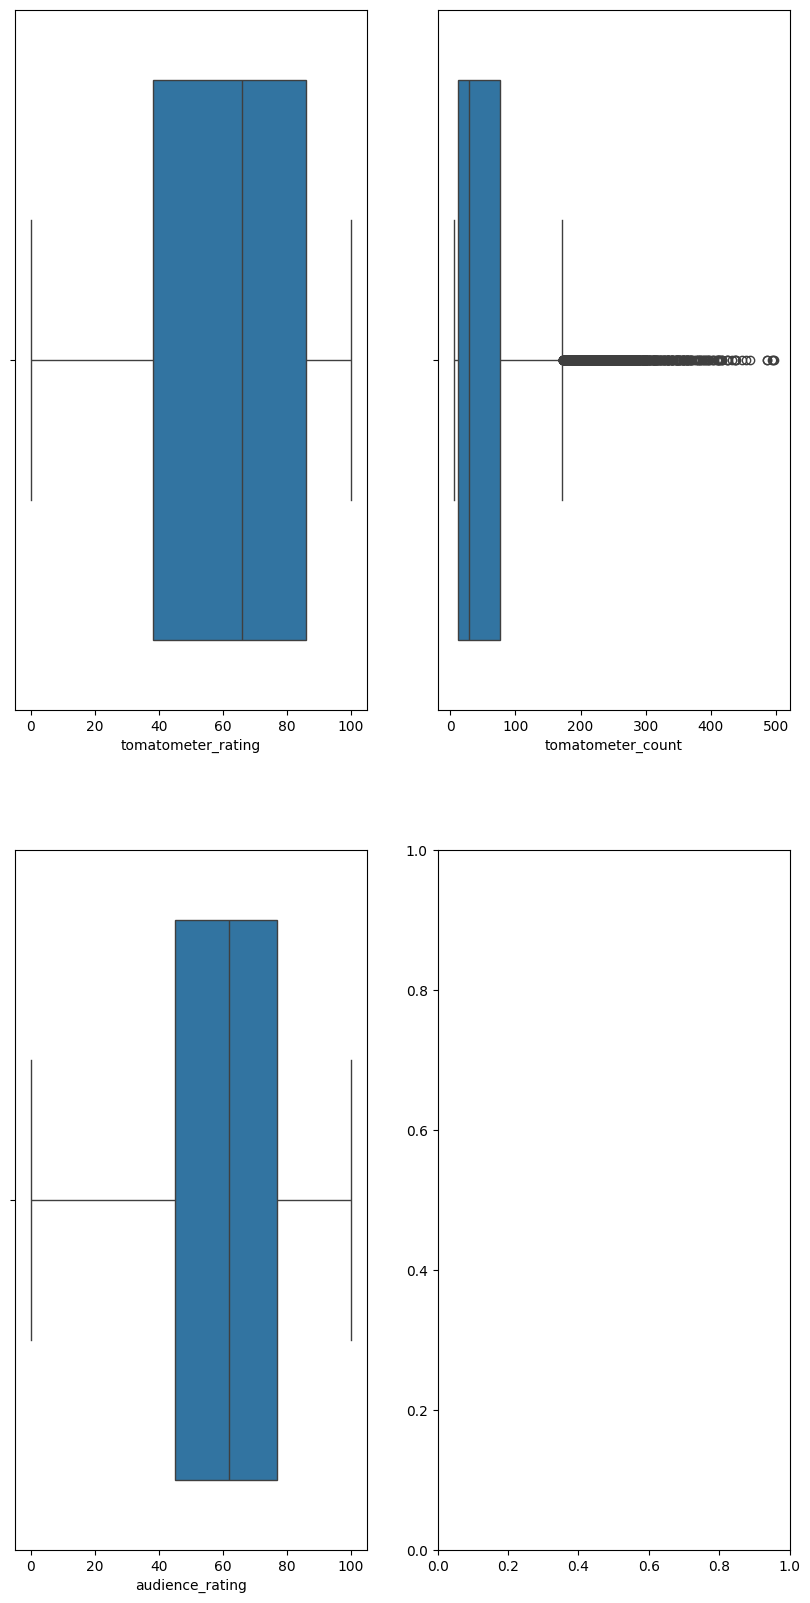

In [44]:
#Columns with high correlation
#Checking for OUTLIERS
box_col = ['tomatometer_rating', 'tomatometer_count', 'audience_rating']
fig, ax = plt.subplots(2, 2, figsize=(10, 20))
ax = ax.flatten()
for index, value in enumerate(box_col):
    sns.boxplot(data=df_movies, x=value, ax=ax[index])

In [45]:
#Removing Outliers
mask1 = df_movies['tomatometer_count'] < iqr(df_movies['tomatometer_count']) * 1.5 + np.percentile(df_movies['tomatometer_count'], 75)

In [46]:
df_movies = df_movies[mask1]

In [47]:
df_movies.shape

(15382, 16)

In [77]:
hist_col = df_movies.select_dtypes(include=['int64','float64','datetime64']).columns
hist_col.shape

(6,)

In [78]:
df_movies.dtypes

,0
movie_title,object
movie_info,object
critics_consensus,object
rating,object
genre,object
directors,object
writers,object
cast,object
in_theaters_date,datetime64[ns]
on_streaming_date,datetime64[ns]


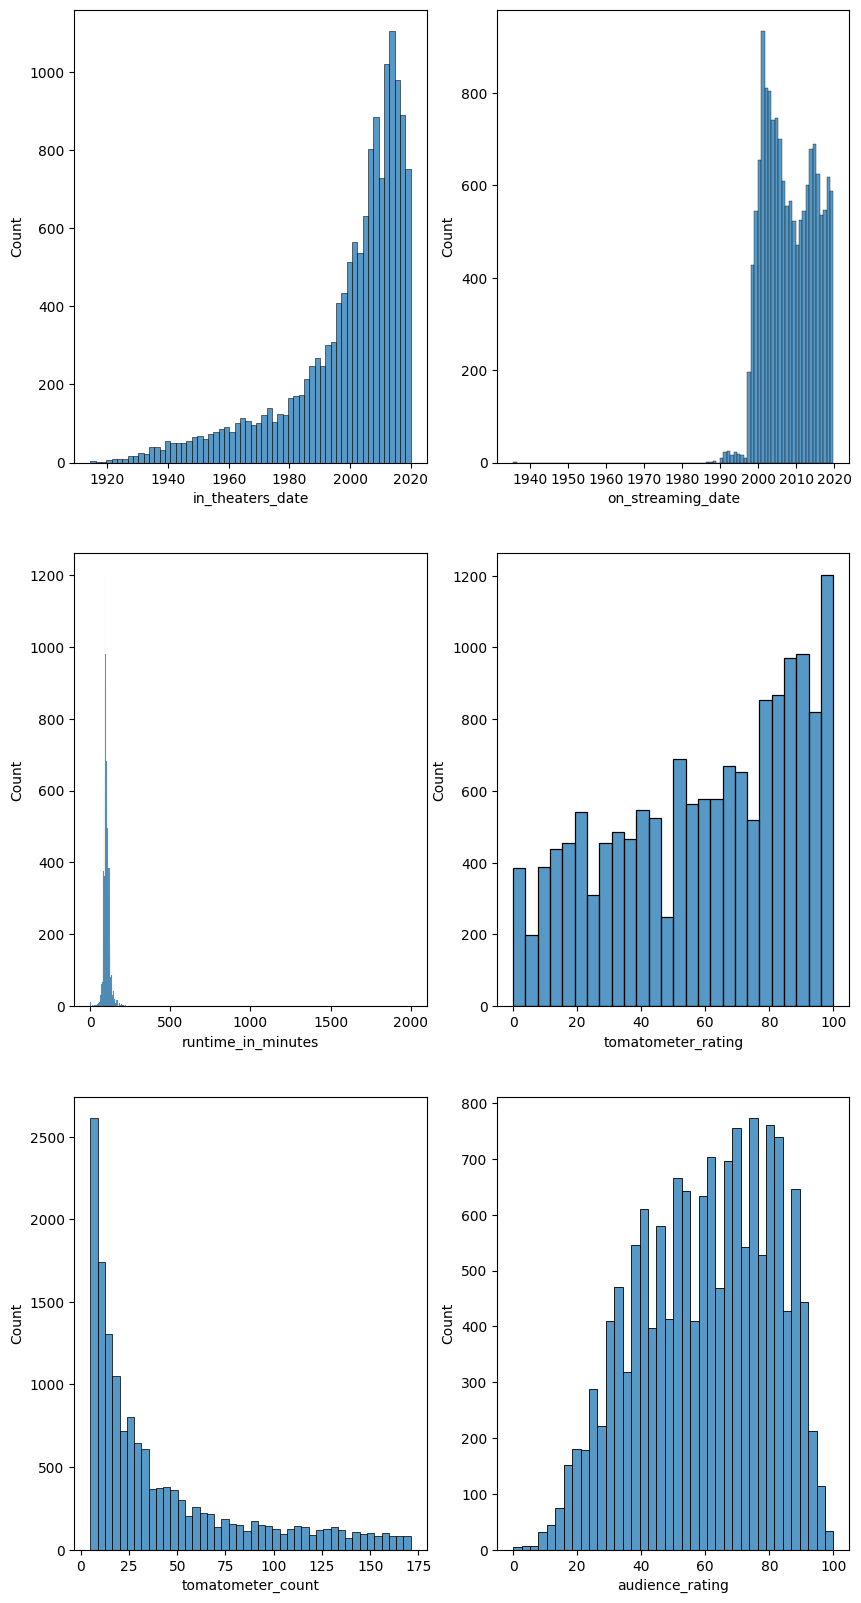

In [80]:
fig, ax = plt.subplots(3, 2, figsize=(10, 20))
ax = ax.flatten()
for index, value in enumerate(hist_col):
    sns.histplot(data=df_movies, x=value, ax=ax[index])

In [87]:
#Encoding content_rating column
content_rating = pd.get_dummies(df_movies['rating']).astype(int)
content_rating

,G,NC17,NR,PG,PG-13,PG-13),R,R)
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
16632,0,0,0,1,0,0,0,0
16633,0,0,0,0,0,0,1,0
16635,0,0,1,0,0,0,0,0
16636,0,0,0,1,0,0,0,0


In [90]:
df_feature = pd.concat([df_movies[['runtime_in_minutes', 'tomatometer_rating', 'tomatometer_count', 'audience_rating' ]], content_rating], axis=1)

In [91]:
df_feature.head()

,runtime_in_minutes,tomatometer_rating,tomatometer_count,audience_rating,G,NC17,NR,PG,PG-13,PG-13),R,R)
0,83.0,49,144,53.0,0,0,0,1,0,0,0,0
1,90.0,86,140,64.0,0,0,0,0,0,0,1,0
2,118.0,68,22,53.0,0,0,0,0,0,0,1,0
3,95.0,100,51,97.0,0,0,1,0,0,0,0,0
4,127.0,89,27,74.0,1,0,0,0,0,0,0,0


Scaling the data

In [92]:
scaler = StandardScaler()
df_feature_scale = scaler.fit_transform(df_feature)
df_feature_scale

array([[-0.72783649, -0.3703541 ,  2.41969157, ..., -0.01396679,
        -0.75163876, -0.00806321],
       [-0.4493273 ,  0.90950399,  2.32455151, ..., -0.01396679,
         1.33042633, -0.00806321],
       [ 0.66470948,  0.28687033, -0.48208029, ..., -0.01396679,
         1.33042633, -0.00806321],
       ...,
       [ 1.61959814,  0.63277792, -0.79128549, ..., -0.01396679,
        -0.75163876, -0.00806321],
       [ 1.50023706,  1.22082082, -0.50586531, ..., -0.01396679,
        -0.75163876, -0.00806321],
       [ 0.62492245, -0.09362802, -0.83885552, ..., -0.01396679,
        -0.75163876, -0.00806321]])

Splitting the data into train set and test set

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_feature_scale, target, test_size=0.2, random_state=42)

In [94]:
print(f'Size of train data: {X_train.shape[0]}\nSize of test data: {X_test.shape[0]}')

Size of train data: 12305
Size of test data: 3077


# Models

# Decision Tree Model

In [95]:
#i will try default params
tree = DecisionTreeClassifier(random_state=2)

In [96]:
tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=2)

[Text(0.31766732283464566, 0.9722222222222222, 'x[1] <= -0.007\ngini = 0.613\nsamples = 12305\nvalue = [1795, 4954, 5556]'),
 Text(0.3097933070866142, 0.9166666666666666, 'gini = 0.0\nsamples = 5556\nvalue = [0, 0, 5556]'),
 Text(0.3137303149606299, 0.9444444444444444, 'True  '),
 Text(0.32554133858267714, 0.9166666666666666, 'x[2] <= -0.066\ngini = 0.39\nsamples = 6749\nvalue = [1795, 4954, 0]'),
 Text(0.3216043307086614, 0.9444444444444444, '  False'),
 Text(0.10531496062992125, 0.8611111111111112, 'x[0] <= -1.424\ngini = 0.005\nsamples = 4353\nvalue = [11, 4342, 0]'),
 Text(0.031496062992125984, 0.8055555555555556, 'x[2] <= -0.542\ngini = 0.077\nsamples = 124\nvalue = [5, 119, 0]'),
 Text(0.023622047244094488, 0.75, 'gini = 0.0\nsamples = 94\nvalue = [0, 94, 0]'),
 Text(0.03937007874015748, 0.75, 'x[0] <= -1.703\ngini = 0.278\nsamples = 30\nvalue = [5, 25, 0]'),
 Text(0.023622047244094488, 0.6944444444444444, 'x[2] <= -0.518\ngini = 0.091\nsamples = 21\nvalue = [1, 20, 0]'),
 Text(0

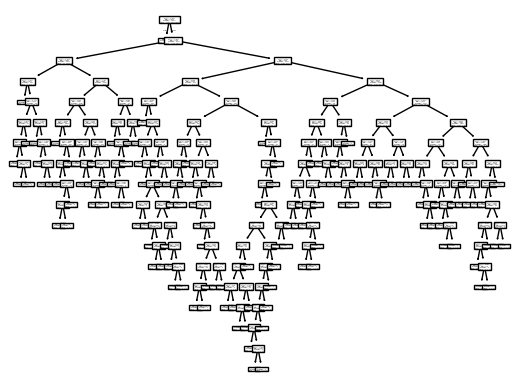

In [97]:
plot_tree(tree)

In [98]:
y_predict = tree.predict(X_test)

## Accuracy of Decision tree model

In [99]:
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

0.983750406239844
                 precision    recall  f1-score   support

Certified Fresh       0.95      0.94      0.95       464
          Fresh       0.98      0.98      0.98      1296
         Rotten       1.00      1.00      1.00      1317

       accuracy                           0.98      3077
      macro avg       0.98      0.98      0.98      3077
   weighted avg       0.98      0.98      0.98      3077



[[ 438   26    0]
 [  24 1272    0]
 [   0    0 1317]]


Text(50.722222222222214, 0.5, 'ACTUAL')

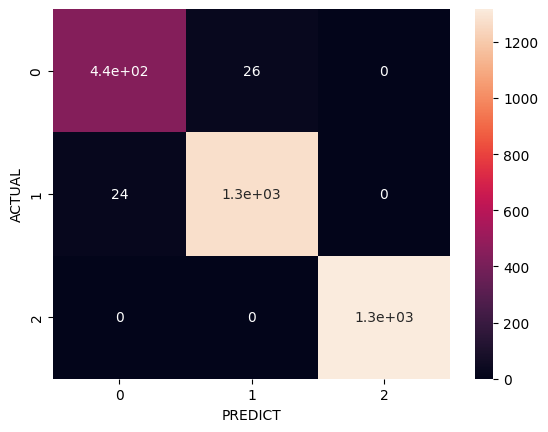

In [100]:
print(confusion_matrix(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.xlabel('PREDICT')
plt.ylabel('ACTUAL')

# Random Forest Model

In [101]:
#Using default parameters
random_forest = RandomForestClassifier(random_state=2)

In [102]:
random_forest.fit(X_train, y_train)
y_predict = random_forest.predict(X_test)

In [103]:
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

0.9896002599935002
                 precision    recall  f1-score   support

Certified Fresh       0.97      0.96      0.97       464
          Fresh       0.99      0.99      0.99      1296
         Rotten       1.00      1.00      1.00      1317

       accuracy                           0.99      3077
      macro avg       0.99      0.98      0.98      3077
   weighted avg       0.99      0.99      0.99      3077



##Accuracy of Random forest model

[[ 445   19    0]
 [  13 1283    0]
 [   0    0 1317]]


Text(50.722222222222214, 0.5, 'ACTUAL')

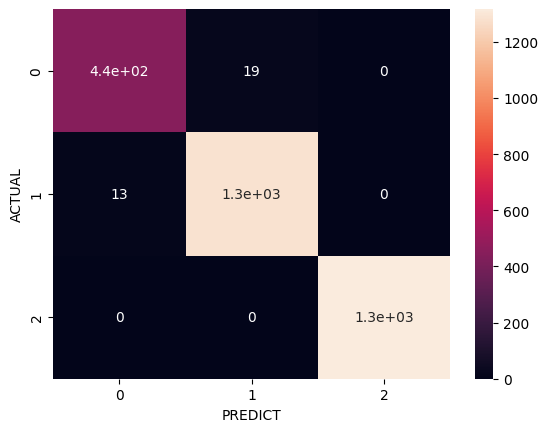

In [104]:
print(confusion_matrix(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.xlabel('PREDICT')
plt.ylabel('ACTUAL')

fruntime_in_minutes: 0.015674096637869027
ftomatometer_rating: 0.6414913179029514
ftomatometer_count: 0.19927781908814762
faudience_rating: 0.10353249459152326
fG: 0.001155284986533397
fNC17: 7.97607580703279e-05
fNR: 0.02476377040473439
fPG: 0.0010476966812899343
fPG-13: 0.006751094004832531
fPG-13): 8.499357760914588e-06
fR: 0.0061899925972718605
fR): 2.817298901544461e-05


([<matplotlib.axis.YTick at 0x78141f89b5b0>,
 [Text(0, 0, 'runtime_in_minutes'),
  Text(0, 1, 'tomatometer_rating'),
  Text(0, 2, 'tomatometer_count'),
  Text(0, 3, 'audience_rating'),
  Text(0, 4, 'G'),
  Text(0, 5, 'NC17'),
  Text(0, 6, 'NR'),
  Text(0, 7, 'PG'),
  Text(0, 8, 'PG-13'),
  Text(0, 9, 'PG-13)'),
  Text(0, 10, 'R'),
  Text(0, 11, 'R)')])

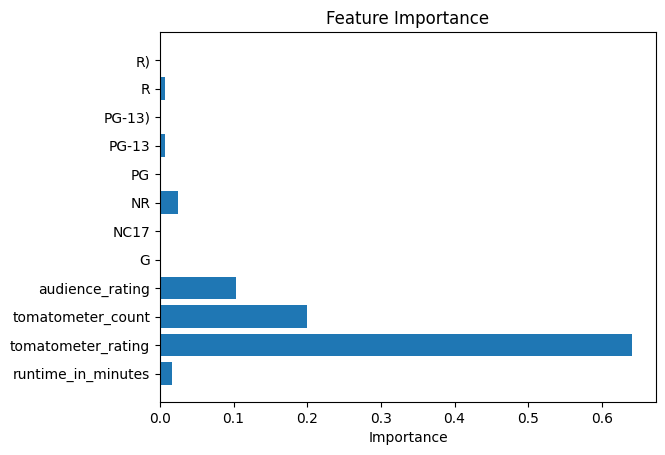

In [105]:
feature_importances = random_forest.feature_importances_
for index, feature in enumerate(df_feature.columns):
    print(f'f{feature}: {feature_importances[index]}')

plt.barh(np.arange(len(feature_importances)), feature_importances)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.yticks(np.arange(len(feature_importances)), df_feature.columns)

Feature Selection

In [108]:
scaler = StandardScaler()
df_feature_scale = scaler.fit_transform(df_feature.drop(['R', 'PG-13', 'PG', 'NR', 'NC17', 'G', 'runtime_in_minutes'], axis=1))
df_feature_scale

array([[-0.3703541 ,  2.41969157, -0.3316058 , -0.01396679, -0.00806321],
       [ 0.90950399,  2.32455151,  0.20215391, -0.01396679, -0.00806321],
       [ 0.28687033, -0.48208029, -0.3316058 , -0.01396679, -0.00806321],
       ...,
       [ 0.63277792, -0.79128549,  1.31819695, -0.01396679, -0.00806321],
       [ 1.22082082, -0.50586531,  1.51229139, -0.01396679, -0.00806321],
       [-0.09362802, -0.83885552,  0.10510669, -0.01396679, -0.00806321]])

In [109]:
X_train, X_test, y_train, y_test = train_test_split(df_feature_scale, target, test_size=0.2, random_state=42)
print(f'Size of train data: {X_train.shape[0]}\nSize of test data: {X_test.shape[0]}')

Size of train data: 12305
Size of test data: 3077


In [110]:
random_forest = RandomForestClassifier(random_state=2)

In [111]:
random_forest.fit(X_train, y_train)
y_predict = random_forest.predict(X_test)

In [112]:
print(accuracy_score(y_test, y_predict))
print(classification_report(y_test, y_predict))

0.9886252843678908
                 precision    recall  f1-score   support

Certified Fresh       0.97      0.96      0.96       464
          Fresh       0.98      0.99      0.99      1296
         Rotten       1.00      1.00      1.00      1317

       accuracy                           0.99      3077
      macro avg       0.98      0.98      0.98      3077
   weighted avg       0.99      0.99      0.99      3077



[[ 444   20    0]
 [  15 1281    0]
 [   0    0 1317]]


Text(50.722222222222214, 0.5, 'ACTUAL')

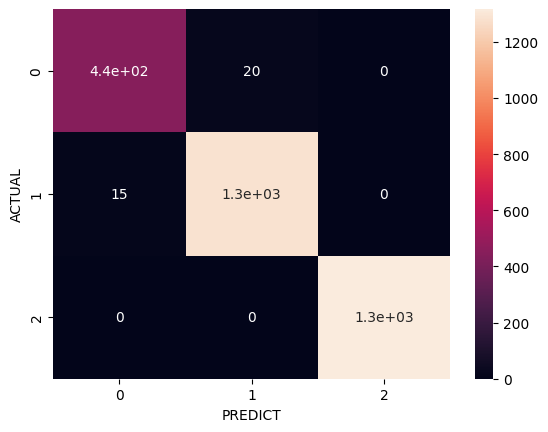

In [113]:
print(confusion_matrix(y_test, y_predict))
sns.heatmap(confusion_matrix(y_test, y_predict), annot=True)
plt.xlabel('PREDICT')
plt.ylabel('ACTUAL')